In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import qiskit_metal as metal
from qiskit_metal import designs, MetalGUI
from qiskit_metal import Dict, Headings

In [3]:
from qiskit_metal.renderers.renderer_ansys.ansys_renderer import QAnsysRenderer
QAnsysRenderer.default_options

{'Lj': '10nH',
 'Cj': 0,
 '_Rj': 0,
 'max_mesh_length_jj': '7um',
 'max_mesh_length_port': '7um',
 'project_path': None,
 'project_name': None,
 'design_name': None,
 'x_buffer_width_mm': 0.2,
 'y_buffer_width_mm': 0.2,
 'wb_threshold': '400um',
 'wb_offset': '0um',
 'wb_size': 5,
 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1',
  'UserSpecifyName': '0',
  'UserSpecifyFolder': '0',
  'QuantityName': 'Mag_E',
  'PlotFolder': 'E Field',
  'StreamlinePlot': 'False',
  'AdjacentSidePlot': 'False',
  'FullModelPlot': 'False',
  'IntrinsicVar': "Phase='0deg'",
  'PlotGeomInfo_0': '1',
  'PlotGeomInfo_1': 'Surface',
  'PlotGeomInfo_2': 'FacesList',
  'PlotGeomInfo_3': '1'}}

In [4]:
design = designs.DesignPlanar()
gui = MetalGUI(design)

In [5]:
from qiskit_metal.qlibrary.qubits.transmon_pocket import TransmonPocket
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander

In [6]:
design.variables['cpw_width'] = '15 um'
design.variables['cpw_gap'] = '9 um'

In [7]:
# Enable overwrite, so that we can re-un this cell multiple times without incurring object name collisions
design.overwrite_enabled = True

# We now define the same custom options for all the transmons.
# We only list the options we intend to modify with respect to the default values
options = Dict(
    pad_width = '425 um',
    pocket_height = '650um',
    # Adding 3 connection_pads
    connection_pads=Dict(
        a = dict(loc_W=+1,loc_H=-1, pad_width='200um'),
        b = dict(loc_W=-1,loc_H=+1, pad_height='30um'),
        c = dict(loc_W=-1,loc_H=-1, pad_height='50um')
    )
)

# Create the 4 transmons
q1 = TransmonPocket(design, 'Q1', options = dict(
    pos_x='+2.42251mm', pos_y='+0.0mm', **options))
q2 = TransmonPocket(design, 'Q2', options = dict(
    pos_x='+0.0mm', pos_y='-0.95mm', orientation = '270', **options))
q3 = TransmonPocket(design, 'Q3', options = dict(
    pos_x='-2.42251mm', pos_y='+0.0mm', orientation = '180', **options))
q4 = TransmonPocket(design, 'Q4', options = dict(
    pos_x='+0.0mm', pos_y='+0.95mm', orientation = '90', **options))

# Now we do the same for the CPWs
options = Dict(
        lead=Dict(
            start_straight='0.2mm',
            end_straight='0.2mm'),
        trace_gap='9um',
        trace_width='15um')

# We define a handy method to shorten the number of line of code necessary to define the 4 CPW
def connect(component_name: str, component1: str, pin1: str, component2: str, pin2: str,
            length: str, asymmetry='0 um', flip=False, fillet='90um'):
    """Connect two pins with a CPW."""
    myoptions = Dict(
        fillet=fillet,
        hfss_wire_bonds = True,
        pin_inputs=Dict(
            start_pin=Dict(
                component=component1,
                pin=pin1),
            end_pin=Dict(
                component=component2,
                pin=pin2)),
        total_length=length)
    myoptions.update(options)
    myoptions.meander.asymmetry = asymmetry
    myoptions.meander.lead_direction_inverted = 'true' if flip else 'false'
    return RouteMeander(design, component_name, myoptions)

# Create the 4 CPWs
asym = 140
cpw1 = connect('cpw1', 'Q1', 'c', 'Q2', 'b', '5.6 mm', f'+{asym}um')
cpw2 = connect('cpw2', 'Q3', 'b', 'Q2', 'c', '5.7 mm', f'-{asym}um', flip=True)
cpw3 = connect('cpw3', 'Q3', 'c', 'Q4', 'b', '5.6 mm', f'+{asym}um')
cpw4 = connect('cpw4', 'Q1', 'b', 'Q4', 'c', '5.7 mm', f'-{asym}um', flip=True)

# Render the entire design to the Qiskit Metal GUI
gui.rebuild()
gui.autoscale()

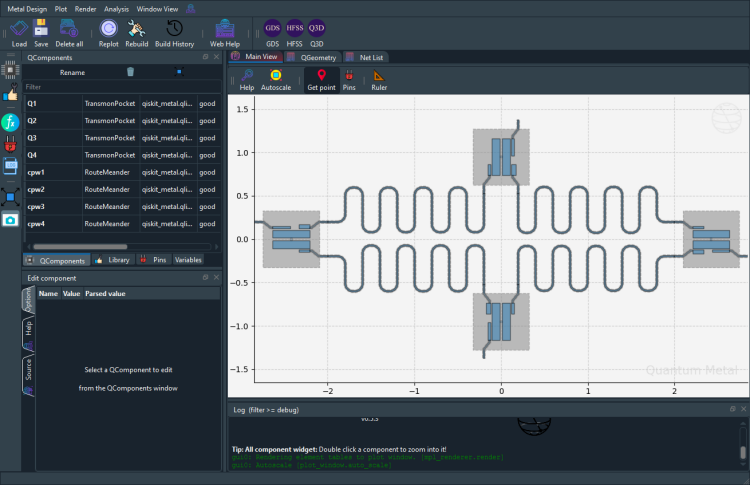

In [8]:
gui.screenshot()

In [9]:
fourq_hfss = design.renderers.hfss

In [10]:
fourq_hfss.start()

INFO 05:13PM [connect_project]: Connecting to Ansys Desktop API...
INFO 05:13PM [load_ansys_project]: 	Opened Ansys App
INFO 05:13PM [load_ansys_project]: 	Opened Ansys Desktop v2025.1.0
INFO 05:13PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/shumail-a/Documents/Ansoft/
	Project:   Project1
INFO 05:13PM [connect_design]: No active design found (or error getting active design).
INFO 05:13PM [connect]: 	 Connected to project "Project1". No design detected


True

In [11]:
ansys_designE = fourq_hfss.new_ansys_design("HFSSQMetalEigenmode", 'eigenmode')
ansys_designE.name

INFO 05:13PM [connect_design]: 	Opened active design
	Design:    HFSSQMetalEigenmode [Solution type: Eigenmode]
WARNING 05:13PM [connect_setup]: 	No design setup detected.
WARNING 05:13PM [connect_setup]: 	Creating eigenmode default setup.
INFO 05:13PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


'HFSSQMetalEigenmode'

In [12]:
fourq_hfss.render_design() 

In [13]:
fourq_hfss.clean_active_design()

In [14]:
fourq_hfss.stop()

True

In [22]:
#ansys_designD = fourq_hfss.new_ansys_design("HFSSQMetalDrivenModal", 'drivenmodal')
#ansys_designD.name

In [23]:
fourq_hfss.activate_ansys_design("HFSSQMetalEigenmode")

INFO 09:32PM [connect_design]: 	Opened active design
	Design:    HFSSQMetalEigenmode [Solution type: Eigenmode]


In [25]:
fourq_hfss.activate_ansys_design("HFSSQMetalDrivenModal")

INFO 09:35PM [connect_design]: 	Opened active design
	Design:    HFSSQMetalDrivenModal [Solution type: HFSS Hybrid Modal Network]


In [28]:
fourq_hfss.render_design(['Q1'], [('Q1', 'b'), ('Q1', 'c')])  # single qubit with 2 endcaps.

In [29]:
fourq_hfss.clean_active_design()
fourq_hfss.render_design(['Q1', 'cpw1', 'Q2'], [('Q1', 'b'), ('Q2', 'c')])  # 2 qubits and 2 endcaps, one per qubit.

In [30]:
fourq_hfss.clean_active_design()
fourq_hfss.render_design(['Q2'], [('Q2', 'a')], [('Q2', 'b', '70')])

In [32]:
design._chips['main']['size']['size_y'] = '6mm'

In [33]:
fourq_hfss.clean_active_design()
fourq_hfss.render_design([], [], box_plus_buffer=False)

In [34]:
fourq_hfss.clean_active_design()
design._chips['main']['size']['size_x'] = '4mm'
fourq_hfss.render_design([], [], box_plus_buffer=False)

In [35]:
#    Return back to original size, for the remainder of the notebook
design._chips['main']['size']['size_x'] = '6mm'

In [36]:
fourq_hfss.clean_active_design()
fourq_hfss.render_design([], [], box_plus_buffer=False)

In [38]:
fourq_q3d = design.renderers.q3d

In [46]:
fourq_q3d.start()

INFO 10:23PM [connect_project]: Connecting to Ansys Desktop API...
INFO 10:23PM [load_ansys_project]: 	Opened Ansys App
INFO 10:23PM [load_ansys_project]: 	Opened Ansys Desktop v2025.1.0
INFO 10:23PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    D:/Box/QuantumMetal/
	Project:   FourQubits
INFO 10:23PM [connect_design]: 	Opened active design
	Design:    Q3DDesign2 [Solution type: Q3D]
WARNING 10:23PM [connect_setup]: 	No design setup detected.
WARNING 10:23PM [connect_setup]: 	Creating Q3D default setup.
INFO 10:23PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 10:23PM [connect]: 	Connected to project "FourQubits" and design "Q3DDesign2" 😀 



True

In [47]:
ansys_design = fourq_q3d.new_ansys_design("Q3dMetalDesign", 'capacitive')
ansys_design.name

INFO 10:23PM [connect_design]: 	Opened active design
	Design:    Q3dMetalDesign [Solution type: Q3D]
WARNING 10:23PM [connect_setup]: 	No design setup detected.
WARNING 10:23PM [connect_setup]: 	Creating Q3D default setup.
INFO 10:23PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)


'Q3dMetalDesign'

In [42]:
fourq_q3d.activate_ansys_design("Q3dMetalDesignNEW", 'capacitive')

10:19PM 31s WARNING [activate_ansys_design]: The design_name=Q3dMetalDesignNEW was not in active project.  Designs in active project are: 
['HFSSQMetalEigenmode', 'HFSSQMetalDrivenModal', 'Q3dMetalDesign'].  A new design will be added to the project.  
INFO 10:19PM [connect_design]: 	Opened active design
	Design:    Q3dMetalDesignNEW [Solution type: Q3D]
WARNING 10:19PM [connect_setup]: 	No design setup detected.
WARNING 10:19PM [connect_setup]: 	Creating Q3D default setup.
INFO 10:19PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)


In [48]:
fourq_q3d.render_design()

In [49]:
fourq_q3d.activate_ansys_setup("SetupNEW")

10:27PM 16s WARNING [activate_ansys_setup]: The setup_name=SetupNEW was not in active design.  Setups in active design are: 
('Setup',).  A new setup will default values will be added to the design.  


In [50]:
fourq_q3d.stop()

True